# Step 7: NE204 Lab 1
## Raw Pulses to Calibrated Spectrum

__Group: Megan Schiferl, Curtis Berger, Chris Lamb, Jisu Park__

__Fall 2022__

__Contents__
The purpose of this notebook is to take in raw pulses from a high purity germanium detector and return a calibrated spectrum, using prevoiusly optimized filtering parameters and calibration curve.

    Section 1: Imports
    Section 2: Splitting the Data
    Section 3: Defining Functions
    Section 4: Calculating Trapezoid Heights from Raw Data (Using the Max Value Method)
    Section 5: Calibrated Spectrum
    

Note: To run this notebook successfully, you'll need to check/change the following:
 - In Section 1: Imports - the second cell is where you'll import the raw pulses from the detector and the calibration paramters. You'll need to change the directory and file names. 
 
 - In Section 2: Splitting the data - depending on the number of pulses in the file, you'll need to change the number of pulsesX arrays to hold ~5000 pulses. This step was necessary for my (Megan's) computer to handle the large file sizes. Thus, the code is built around this structure. Section 1 has an output that will tell you the number of pulseX arrays to use. 
 
Once you have these parts checked and changed, you can run the rest of the notebook through to get your spectrum!

# Section 1: Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import pandas as pd
from scipy import signal
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import os
from tqdm import notebook
import matplotlib.colors as mcolors
from decimal import Decimal

In [2]:
################Import Raw Pulses Here######################################

# change directory
yourdirectory = r'C:/Users/megas/Documents/Cal/NEFall2022/Detectors204/lab1/'
os.chdir(yourdirectory)

#Import the raw pulse data
path = r'C:\Users\megas\Documents\Cal\NEFall2022\Detectors204\lab1\FinalData\Cs137-24in-2.h5'
f = h5py.File(path, 'r')

############# Calibration Parameters here ################################
os.chdir(r'C:\Users\megas\Documents\Cal\NEFall2022\Detectors204\lab2\PulsesPE')
calib = pd.read_csv("CalibrationParameters.csv")
calib = np.array(calib)

In [3]:
#Save the data into an array for analysis
pulses = np.array(f['raw_data'])

f.close()
#Remove the last second of pulses due to DAC mistake (approximate)
pulses = pulses[:-140]

print("The number of pulses in this file is:", len(pulses))
print("The length of each pulse is:", len(pulses[0]))
print("The number of pulsesX arrays you will need is:", int(len(pulses)/5000)+1)

The number of pulses in this file is: 16005
The length of each pulse is: 62500
The number of pulsesX arrays you will need is: 4


# Section 2: Splitting the Data

In [4]:
#Split the large files up into different arrays
#This part has to happen in my code because my computer sucks and can only run 5000 pulses through a for loop at one time without crashing...
pulses1 = []
pulses2 = []
pulses3 = []
pulses4 = []
# pulses5 = []
# pulses6 = []
# pulses7 = []
for i in notebook.tqdm(range(len(pulses))):
    if i < 5000:
        pulses1.append(pulses[i])
    elif i < 10000:
        pulses2.append(pulses[i])
    elif i < 15000:
        pulses3.append(pulses[i])
    elif i < 20000:
        pulses4.append(pulses[i])
#     elif i < 25000:
#         pulses5.append(pulses[i])
#     elif i < 30000:
#         pulses6.append(pulses[i])
#     else:
#         pulses7.append(pulses[i])

pulse_names = [pulses1, pulses2, pulses3, pulses4]
#                , pulses5, pulses6, pulses7]
        
print("The lengths of each array are as follows: ", len(pulses1), len(pulses2), len(pulses3), len(pulses4))
#       len(pulses5), len(pulses6), len(pulses7))

  0%|          | 0/16005 [00:00<?, ?it/s]

The lengths of each array are as follows:  5000 5000 5000 1005


# Section 3: Defining Functions

In [5]:
#defining an exponential function
def exp_func(x, a, b, c):
    #returns a times e^(-b times a) + c
    return a * np.exp(-b * x) + c
    
#Finding the start of rise index using V4 from the notes notebook
def determine_rise(signal, sigma=8, window=20, offset=15):
    noise_samp = signal[:500]
    mean, std = np.mean(noise_samp), np.std(noise_samp)

    grad = np.gradient(np.where(signal > mean+sigma*std, signal, 0))

    grad_pos, grad_neg = np.argwhere(grad>2), np.argwhere(grad<-2)

    rise_start = 0
    for gp in grad_pos:
        close = False
        for gn in grad_neg:
            if (gp-gn < window and gp-gn >0):
                close = True
        if not close:
            rise_start = gp
            break

    return int(rise_start-offset)

#Define the trapezoidal filter and signal output function
def delay_signal(signal, delay, p=500):
    np.random.seed(9)
    noise_samp = signal[:p]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    noise = np.random.normal(mean, 0.8*std, delay)
    return np.hstack([noise, signal])

def dkl(signal, i, k, l, w=0):
    if w == 0:
        w = int(2.5*k+l)
    vj = signal[i+w:i+w+w] 
    vjk = signal[i+w-k:i+w-k+w]
    vjl = signal[i+w-l:i+w-l+w]
    vjkl = signal[i+w-k-l:i+w-k-l+w]
    dkl_s = vj - vjk - vjl + vjkl
    return dkl_s

def sfunc(signal, start_rise, tau, peaking_time, gap_time, w=0):
    if w == 0:
        w = int(2.5*peaking_time+gap_time)
    ss = []
    dkl_s = dkl(signal, start_rise, peaking_time, peaking_time+gap_time, w)
    for j in range(w):
        if j == 0:
            ss.append(0)
        else:
            ss.append(ss[j-1]*(1+1/tau)+ dkl_s[j])
    return np.array(ss)

#Define a gaussian function for fitting 
def gauss(x, H, A, x0, sigma):
    # Gaussian signal shape
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

#using the gaussian function to fit signals 
def gauss_fit(x, y):
    # Fits gaussian and returns fit parameters
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

#Function for energy calibration
def calibrate_energy(ch, a1, a2, a3, a4, a5, b):
    # Energy calibrate channel number given calibration constants
    return a1*ch + a2*ch**2 + a3*ch**3 + a4*ch**4 + a5*ch**5 + b



# Section 4: Calculating Trapezoid Heights from Raw Pulse Data 
## Using the Maximum Value Method

In [6]:
#Calculate Trapzoid heights
##################################################################################
#del allheights
allheights = []
for i in notebook.tqdm(range(len(pulse_names)), desc = "Iteration Over Chunks of Pulses"):
    pulsesX = pulse_names[i]
    k = 950  #previously optimized peaking time 
    m = 1000  #previously optimized gap time
    l = k+m
    
    #remove saturated signals
    sat = np.amax(np.amax(pulsesX))

    nonsat_pulses = []
    for a in notebook.tqdm(range(len(pulsesX)), desc="Removing Saturated Pulses", leave = False):
        max_y = np.amax(pulsesX[a])
        if (max_y != sat):
            nonsat_pulses.append(pulsesX[a])

    nonsat_pulses = np.array(nonsat_pulses)   

    #Background subtraction for the raw data
    n = len(nonsat_pulses)
    pulses_sub = []
    for c in notebook.tqdm(range(n), desc = "Noise Floor Subtraction", leave = False):
        bkg = np.mean(nonsat_pulses[c][0:500])
        pulses_sub.append(nonsat_pulses[c] - bkg)

    pulses_sub = np.array(pulses_sub)

    #filtering the signals
    fs = savgol_filter(pulses_sub, 53, 2)

    #find the index of the max value for each fitted signal
    imax = []
    for q in notebook.tqdm(range(len(fs)), desc = "Finding index of max", leave = False):
        if np.argmax(fs[q][0:2000]) != 1999:
            imax.append(np.argmax(fs[q][0:2000])) # only looking at the first 2000 to avoid late pileup signals

    #fit an exponential curve to the decay of each signal to find tau
    if i == 0:
        tau = []
        for d in notebook.tqdm(range(100), desc = "Finding Tau", leave = False):
            #setting the ranges for exp fitting and x axis parameters
            endfit = 20000
            s = imax[d] #index of max for pulse d
            x = np.arange(0, endfit) #array of values from max index upward for some number of indices, len(x)=endfit

            #using exp_func over the values in x
            #fits an exp to the ith pulse from index of max to endfit+index of max
            try:
                popt, pcov = curve_fit(exp_func, x, fs[d][s:endfit+s])
                tau.append(1/popt[1])
            except:
                tau.append(0)

        tau = list(filter(lambda a: a != 0, tau))
        tau = np.array(tau)
        Tau = int(np.mean(tau))

    #Place all i in an array
    startrise = []
    for q2 in notebook.tqdm(range(len(fs)), desc = "Finding the start rise index", leave = False):
        itemp = int(determine_rise(fs[q2]))
        startrise.append(itemp)
    startrise = np.array(startrise)

    #Delay the signals 
    dfs = []
    d=int(2.5*k+m)
    for r in notebook.tqdm(range(len(fs)), desc = "Delaying Signals", leave = False):
        tempfs = delay_signal(fs[r],delay=d)
        dfs.append(tempfs)
    dfs = np.array(dfs)

    #Calculate the trapezoids
    traps = []
    for t in notebook.tqdm(range(len(dfs)), desc = "Calculating Trapezoids", leave = False):
        trap = sfunc(dfs[t], startrise[t], Tau, k, m)
        traps.append(trap)

    #Find the maximum height of the trapezoids
    height = []
    for u in notebook.tqdm(range(len(traps)), desc = "Finding Heights", leave = False):
        height.append(np.amax(traps[u]))
    
    height = list(filter(lambda a: a >= 0, height))    
    allheights = allheights + height
        
allheights = np.array(allheights)

Iteration Over Chunks of Pulses:   0%|          | 0/4 [00:00<?, ?it/s]

Removing Saturated Pulses:   0%|          | 0/5000 [00:00<?, ?it/s]

Noise Floor Subtraction:   0%|          | 0/4982 [00:00<?, ?it/s]

Finding index of max:   0%|          | 0/4982 [00:00<?, ?it/s]

Finding Tau:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Finding the start rise index:   0%|          | 0/4982 [00:00<?, ?it/s]

Delaying Signals:   0%|          | 0/4982 [00:00<?, ?it/s]

Calculating Trapezoids:   0%|          | 0/4982 [00:00<?, ?it/s]

Finding Heights:   0%|          | 0/4982 [00:00<?, ?it/s]

Removing Saturated Pulses:   0%|          | 0/5000 [00:00<?, ?it/s]

Noise Floor Subtraction:   0%|          | 0/4986 [00:00<?, ?it/s]

Finding index of max:   0%|          | 0/4986 [00:00<?, ?it/s]

Finding the start rise index:   0%|          | 0/4986 [00:00<?, ?it/s]

Delaying Signals:   0%|          | 0/4986 [00:00<?, ?it/s]

Calculating Trapezoids:   0%|          | 0/4986 [00:00<?, ?it/s]

Finding Heights:   0%|          | 0/4986 [00:00<?, ?it/s]

Removing Saturated Pulses:   0%|          | 0/5000 [00:00<?, ?it/s]

Noise Floor Subtraction:   0%|          | 0/4986 [00:00<?, ?it/s]

Finding index of max:   0%|          | 0/4986 [00:00<?, ?it/s]

Finding the start rise index:   0%|          | 0/4986 [00:00<?, ?it/s]

Delaying Signals:   0%|          | 0/4986 [00:00<?, ?it/s]

Calculating Trapezoids:   0%|          | 0/4986 [00:00<?, ?it/s]

Finding Heights:   0%|          | 0/4986 [00:00<?, ?it/s]

Removing Saturated Pulses:   0%|          | 0/1005 [00:00<?, ?it/s]

Noise Floor Subtraction:   0%|          | 0/1004 [00:00<?, ?it/s]

Finding index of max:   0%|          | 0/1004 [00:00<?, ?it/s]

Finding the start rise index:   0%|          | 0/1004 [00:00<?, ?it/s]

Delaying Signals:   0%|          | 0/1004 [00:00<?, ?it/s]

Calculating Trapezoids:   0%|          | 0/1004 [00:00<?, ?it/s]

Finding Heights:   0%|          | 0/1004 [00:00<?, ?it/s]

# Section 5: Calibrated Spectrum

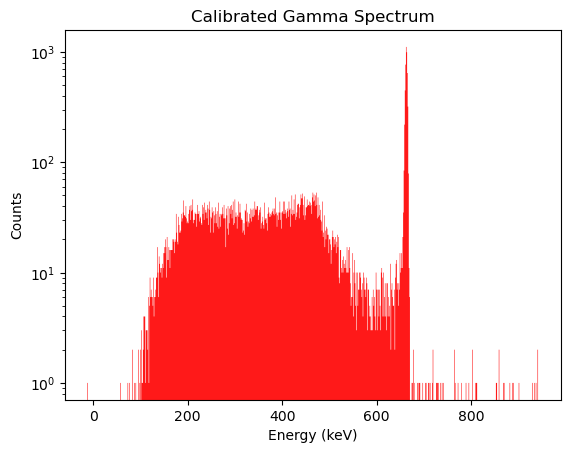

In [7]:
bh = []
gh = []
for i in range(len(allheights)):
    if allheights[i] > 2*np.mean(allheights):
        bh.append(allheights[i])
    else:
        gh.append(allheights[i])

gh = np.array(gh)

calibrated_heights = []
for i in range(len(gh)):
    temp = calibrate_energy(gh[i], *calib)
    calibrated_heights.append(temp)
    
calibrated_heights = np.array(calibrated_heights)

plt.figure()
plt.title("Calibrated Gamma Spectrum")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.semilogy()
spectrum, bins = np.histogram(calibrated_heights, bins=int(len(calibrated_heights)/20)) #bins of width 20 channels
plt.hist(bins[:-1], bins, weights = spectrum, histtype='stepfilled', color='r',alpha = 0.9, 
         label = "Gamma Spectrum")
plt.show()